In [1]:
import os
import random
import xml.etree.ElementTree as ET
import cv2 # OpenCV
import matplotlib.pyplot as plt
import matplotlib.patches as patches # To draw rectangles

# Ensure plots show up in the notebook
%matplotlib inline

In [2]:
# Define the base path to your raw data
# Adjust this path if your notebook is not directly in the 'notebooks' folder
# relative to the IA2 root directory.
base_data_path = '../data/raw/' # Go up one level from notebooks/ to IA2/, then into data/raw/

romanian_data_path = os.path.join(base_data_path, 'romanian_dataset')
spanish_data_path = os.path.join(base_data_path, 'spanish_dataset')

print(f"Romanian dataset path: {romanian_data_path}")
print(f"Spanish dataset path: {spanish_data_path}")
print(f"Romanian path exists: {os.path.exists(romanian_data_path)}")
print(f"Spanish path exists: {os.path.exists(spanish_data_path)}")

Romanian dataset path: ../data/raw/romanian_dataset
Spanish dataset path: ../data/raw/spanish_dataset
Romanian path exists: True
Spanish path exists: True


In [3]:
def visualize_image_with_boxes(image_path, boxes, title="Image"):
    """
    Displays an image with bounding boxes drawn on it.

    Args:
        image_path (str): Path to the image file.
        boxes (list): A list of boxes, where each box is a tuple
                      (xmin, ymin, xmax, ymax).
        title (str): Title for the plot.
    """
    try:
        # Read the image using OpenCV (reads in BGR format)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Could not read image at {image_path}")
            return
        # Convert BGR to RGB for matplotlib display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Create figure and axes
        fig, ax = plt.subplots(1, figsize=(10, 8))

        # Display the image
        ax.imshow(image_rgb)
        ax.set_title(title)

        # Draw the bounding boxes
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            # Ensure coordinates are integers
            xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)

            # Create a Rectangle patch
            # Matplotlib patches need (x, y) of bottom-left corner, width, height
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor='r', # Red color for the box
                facecolor='none' # No fill
            )
            # Add the patch to the Axes
            ax.add_patch(rect)

        # Remove axes ticks
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")
        print(f"Image path: {image_path}")
        print(f"Boxes: {boxes}")

--- Testing Romanian Dataset ---
Selected Image: ../data/raw/romanian_dataset\train\images\nightride_type3_001.mp4#t=18.jpg
Annotation File: ../data/raw/romanian_dataset\train\annots\nightride_type3_001.mp4#t=18.xml
Number of bounding boxes found: 1


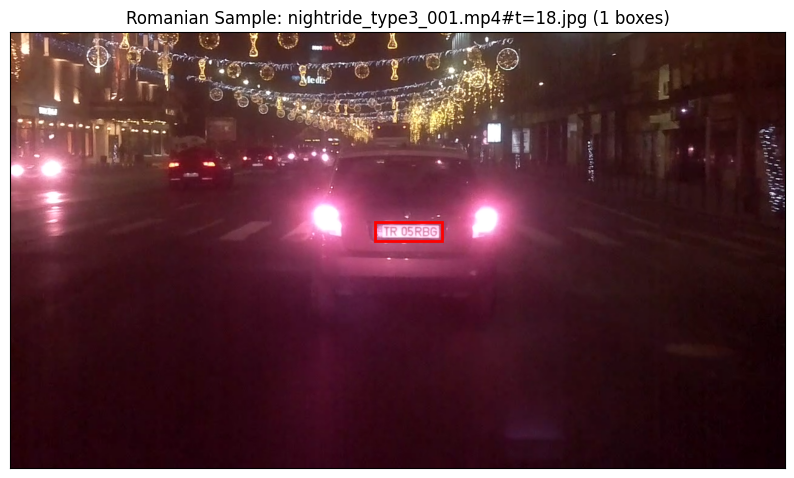

In [32]:
# --- Minor Modifications to Cell 4 ---
print("--- Testing Romanian Dataset ---")

try:
    # Define paths for Romanian train set
    romanian_train_img_dir = os.path.join(romanian_data_path, 'train', 'images')
    romanian_train_annot_dir = os.path.join(romanian_data_path, 'train', 'annots')

    # List image files and pick a random one
    image_files = [f for f in os.listdir(romanian_train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("Error: No image files found in Romanian train images directory.")
    else:
        random_image_name = random.choice(image_files)
        image_path = os.path.join(romanian_train_img_dir, random_image_name)
        annot_name = os.path.splitext(random_image_name)[0] + '.xml'
        annot_path = os.path.join(romanian_train_annot_dir, annot_name)

        print(f"Selected Image: {image_path}")
        print(f"Annotation File: {annot_path}")

        # Parse the XML annotation file
        boxes = []
        box_count = 0 # <-- Add counter
        if os.path.exists(annot_path):
            tree = ET.parse(annot_path)
            root = tree.getroot()
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                if bndbox is not None:
                    xmin = float(bndbox.find('xmin').text)
                    ymin = float(bndbox.find('ymin').text)
                    xmax = float(bndbox.find('xmax').text)
                    ymax = float(bndbox.find('ymax').text)
                    boxes.append((xmin, ymin, xmax, ymax))
                    # print(f"  Found box: ({xmin}, {ymin}, {xmax}, {ymax})") # Optional print
                    box_count += 1 # <-- Increment counter
            if not boxes:
                print("  No <object> tags with <bndbox> found in XML.")
        else:
            print(f"Error: Annotation file not found: {annot_path}")

        print(f"Number of bounding boxes found: {box_count}") # <-- Print count

        # Visualize if boxes were found
        if boxes:
            visualize_image_with_boxes(image_path, boxes, title=f"Romanian Sample: {random_image_name} ({box_count} boxes)")
        elif os.path.exists(image_path):
             print("Visualizing image without boxes as none were found in annotation.")
             visualize_image_with_boxes(image_path, [], title=f"Romanian Sample (No Boxes Found): {random_image_name}")

except Exception as e:
    print(f"An error occurred while testing Romanian dataset: {e}")


--- Testing Spanish Dataset (UC3M-LP JSON Structure) ---
Selected Base ID: 00222
Image Path: ../data/raw/spanish_dataset\train\00222.jpg
JSON Path: ../data/raw/spanish_dataset\train\00222.json
  Plate 1/1: Text='AD-899*C*R', Chars Found=5
Number of license plates found: 1


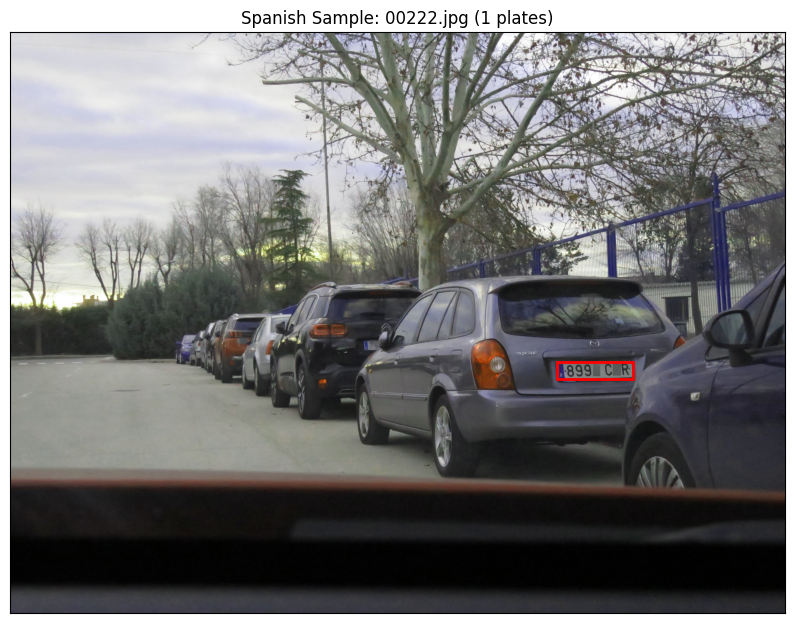

In [36]:
# --- Minor Modifications to Cell 5 ---
import json
import numpy as np

print("\n--- Testing Spanish Dataset (UC3M-LP JSON Structure) ---")

try:
    # Define paths for Spanish train set
    spanish_train_dir = os.path.join(spanish_data_path, 'train')
    train_txt_path = os.path.join(spanish_data_path, 'train.txt')

    # Read the list of base IDs from train.txt
    base_ids = []
    if os.path.exists(train_txt_path):
        with open(train_txt_path, 'r') as f:
            base_ids = [line.strip() for line in f if line.strip()]
        if not base_ids:
             print("Warning: train.txt is empty or could not be read properly.")
    else:
        print(f"Error: {train_txt_path} not found.")

    if not base_ids:
        print("Error: Could not get any base IDs for Spanish training images.")
    else:
        # Pick a random base ID
        random_id = random.choice(base_ids)
        print(f"Selected Base ID: {random_id}")

        # Construct image and JSON paths
        image_filename = f"{random_id}.jpg"
        json_filename = f"{random_id}.json"
        image_path = os.path.join(spanish_train_dir, image_filename)
        json_path = os.path.join(spanish_train_dir, json_filename)

        print(f"Image Path: {image_path}")
        print(f"JSON Path: {json_path}")

        boxes = []
        plate_count = 0 # <-- Add counter
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r') as f:
                    data = json.load(f)

                if 'lps' in data and isinstance(data['lps'], list):
                    plate_count = len(data['lps']) # <-- Count plates directly
                    for i, lp_annotation in enumerate(data['lps']):
                        # --- Print LP ID and Char Count ---
                        lp_text = lp_annotation.get("lp_id", "N/A")
                        char_list = lp_annotation.get("characters", [])
                        print(f"  Plate {i+1}/{plate_count}: Text='{lp_text}', Chars Found={len(char_list)}")
                        # --- End Print ---

                        if 'poly_coord' in lp_annotation and isinstance(lp_annotation['poly_coord'], list):
                            polygon_points = lp_annotation['poly_coord']
                            if polygon_points:
                                np_points = np.array(polygon_points)
                                xmin = np.min(np_points[:, 0])
                                ymin = np.min(np_points[:, 1])
                                xmax = np.max(np_points[:, 0])
                                ymax = np.max(np_points[:, 1])
                                boxes.append((xmin, ymin, xmax, ymax))
                                # print(f"    Calculated Box: ({xmin:.0f}, {ymin:.0f}, {xmax:.0f}, {ymax:.0f})") # Optional
                            # else: print("  Found 'poly_coord' but it was empty.") # Less verbose
                        # else: print("  Skipping LP annotation, missing 'poly_coord' or not a list.") # Less verbose
                # else: print("  'lps' key not found or not a list in JSON.") # Less verbose

                if not boxes:
                    print(f"  No valid license plate bounding boxes derived from {json_path}.")

            except json.JSONDecodeError: print(f"Error: Could not decode JSON file: {json_path}")
            except Exception as e_parse: print(f"Error parsing JSON content or calculating bounds: {e_parse}")
        else:
            print(f"Error: Annotation JSON file not found: {json_path}")

        print(f"Number of license plates found: {plate_count}") # <-- Print count

        # Visualize if boxes were found
        if boxes:
            visualize_image_with_boxes(image_path, boxes, title=f"Spanish Sample: {image_filename} ({plate_count} plates)")
        elif os.path.exists(image_path):
             print("Visualizing image without boxes as none were found/parsed in annotation.")
             visualize_image_with_boxes(image_path, [], title=f"Spanish Sample (No Boxes Found/Parsed): {image_filename}")
        else:
            print(f"Error: Image file not found: {image_path}")

except Exception as e:
    print(f"An error occurred while testing Spanish dataset: {e}")

--- Analyzing Image Dimensions ---
Sampling 20 images from Romanian train set...
Sampling 20 images from Spanish train set...

--- Image Dimension Statistics ---
         width                             height                            
           min   max    mean  median  mode    min   max    mean  median  mode
dataset                                                                      
Romanian  1280  1280  1280.0  1280.0  1280    720   720   720.0   720.0   720
Spanish   5184  9248  6097.6  5184.0  5184   3888  6944  4341.6  3888.0  3888


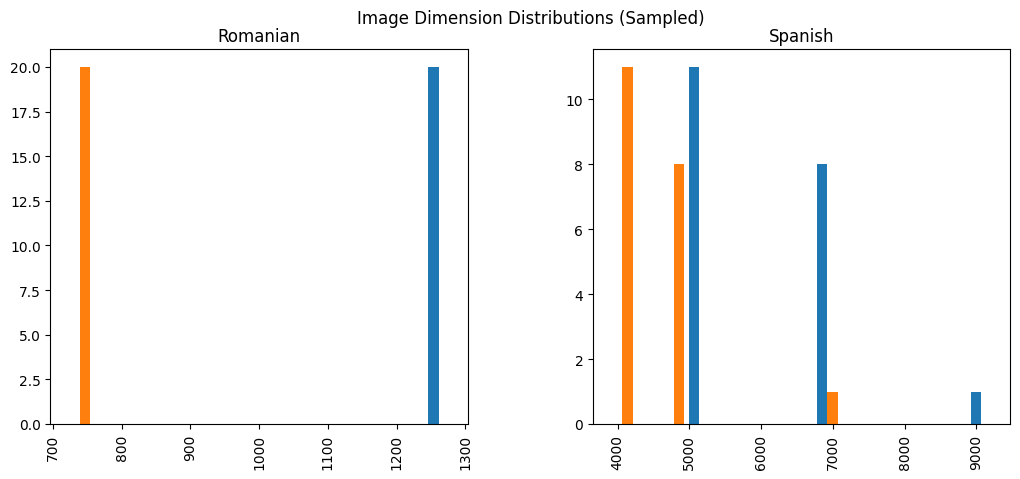

In [38]:
# --- New Cell: Image Size Statistics ---
import pandas as pd # Using pandas for easy stats calculation

print("--- Analyzing Image Dimensions ---")

num_samples = 20 # How many images to check from each dataset
all_dims = {'dataset': [], 'width': [], 'height': []}

# Analyze Romanian Dataset
romanian_train_img_dir = os.path.join(romanian_data_path, 'train', 'images')
romanian_image_files = [f for f in os.listdir(romanian_train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
if romanian_image_files:
    print(f"Sampling {min(num_samples, len(romanian_image_files))} images from Romanian train set...")
    for i in range(min(num_samples, len(romanian_image_files))):
        img_name = random.choice(romanian_image_files)
        img_path = os.path.join(romanian_train_img_dir, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                all_dims['dataset'].append('Romanian')
                all_dims['width'].append(w)
                all_dims['height'].append(h)
            else:
                print(f"Warning: Could not load Romanian image: {img_path}")
        except Exception as e:
            print(f"Warning: Error processing Romanian image {img_path}: {e}")
else:
    print("No Romanian images found to analyze.")


# Analyze Spanish Dataset
spanish_train_dir = os.path.join(spanish_data_path, 'train')
train_txt_path = os.path.join(spanish_data_path, 'train.txt')
spanish_base_ids = []
if os.path.exists(train_txt_path):
    with open(train_txt_path, 'r') as f:
        spanish_base_ids = [line.strip() for line in f if line.strip()]

if spanish_base_ids:
    print(f"Sampling {min(num_samples, len(spanish_base_ids))} images from Spanish train set...")
    for i in range(min(num_samples, len(spanish_base_ids))):
        base_id = random.choice(spanish_base_ids)
        img_name = f"{base_id}.jpg"
        img_path = os.path.join(spanish_train_dir, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                h, w = img.shape[:2]
                all_dims['dataset'].append('Spanish')
                all_dims['width'].append(w)
                all_dims['height'].append(h)
            else:
                print(f"Warning: Could not load Spanish image: {img_path}")
        except Exception as e:
            print(f"Warning: Error processing Spanish image {img_path}: {e}")
else:
    print("No Spanish image IDs found to analyze.")


# Display Statistics using Pandas DataFrame
if all_dims['dataset']:
    df_dims = pd.DataFrame(all_dims)
    print("\n--- Image Dimension Statistics ---")
    print(df_dims.groupby('dataset').agg(['min', 'max', 'mean', 'median', pd.Series.mode])) # Show common sizes too
    
    # Optional: Plot histograms
    df_dims.hist(column=['width', 'height'], by='dataset', figsize=(12, 5), bins=15)
    plt.suptitle('Image Dimension Distributions (Sampled)')
    plt.show()
else:
    print("\nNo dimension data collected.")


--- Analyzing Bounding Box Sizes ---
Sampling 20 annotated images from Romanian train set...
Sampling 20 annotated images from Spanish train set...

--- Bounding Box Size Statistics (Sampled) ---
           box_width                                      box_height  \
                 min          max        mean      median        min   
dataset                                                                
Romanian   45.240108   247.050309  105.594351   90.480215  12.295082   
Spanish   103.000000  1324.000000  450.400000  390.000000  35.000000   

                                            area_perc                      \
                 max        mean     median       min       max      mean   
dataset                                                                     
Romanian   62.557353   28.111475  23.606557  0.060355  1.676955  0.381528   
Spanish   376.000000  126.760000  97.000000  0.039915  1.229935  0.292156   

                    
            median  
dataset       

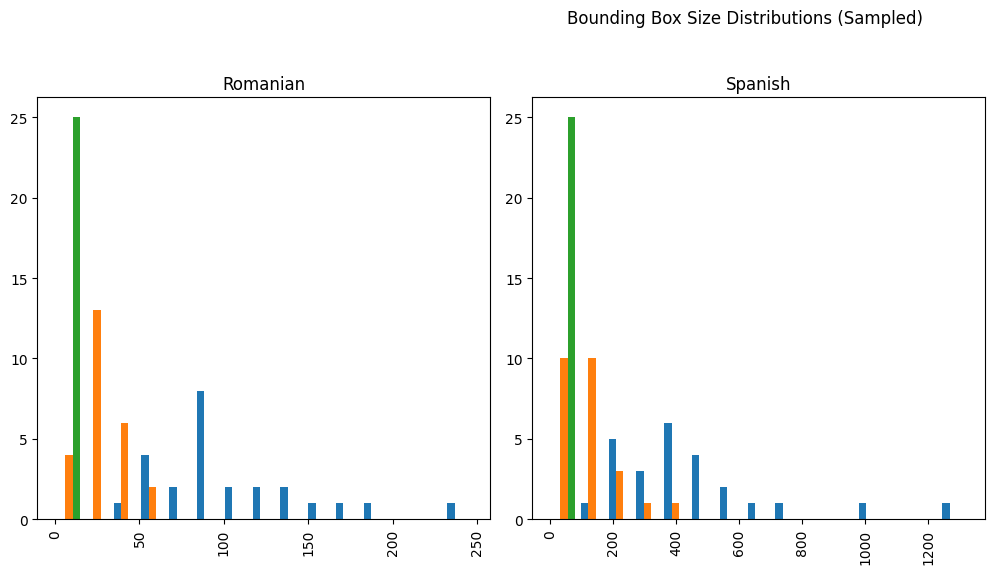

In [39]:
# --- New Cell: Bounding Box Size Statistics ---
import pandas as pd

print("\n--- Analyzing Bounding Box Sizes ---")

num_samples = 20 # How many annotated images to check from each dataset
all_boxes = {'dataset': [], 'box_width': [], 'box_height': [], 'box_area': [], 'img_area': [], 'area_perc': []}

# --- Analyze Romanian Dataset ---
romanian_train_img_dir = os.path.join(romanian_data_path, 'train', 'images')
romanian_train_annot_dir = os.path.join(romanian_data_path, 'train', 'annots')
romanian_image_files = [f for f in os.listdir(romanian_train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

if romanian_image_files:
    print(f"Sampling {min(num_samples, len(romanian_image_files))} annotated images from Romanian train set...")
    sampled_count = 0
    attempts = 0
    max_attempts = num_samples * 3 # Try a bit harder to find annotated images

    while sampled_count < num_samples and attempts < max_attempts and romanian_image_files:
        attempts += 1
        img_name = random.choice(romanian_image_files)
        img_path = os.path.join(romanian_train_img_dir, img_name)
        annot_name = os.path.splitext(img_name)[0] + '.xml'
        annot_path = os.path.join(romanian_train_annot_dir, annot_name)

        try:
            img = cv2.imread(img_path)
            if img is None or not os.path.exists(annot_path):
                continue # Skip if image or annotation missing

            img_h, img_w = img.shape[:2]
            img_area = img_h * img_w

            tree = ET.parse(annot_path)
            root = tree.getroot()
            found_box_in_file = False
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                if bndbox is not None:
                    found_box_in_file = True
                    xmin = float(bndbox.find('xmin').text)
                    ymin = float(bndbox.find('ymin').text)
                    xmax = float(bndbox.find('xmax').text)
                    ymax = float(bndbox.find('ymax').text)

                    box_w = xmax - xmin
                    box_h = ymax - ymin
                    box_area = box_w * box_h
                    area_perc = (box_area / img_area) * 100 if img_area > 0 else 0

                    all_boxes['dataset'].append('Romanian')
                    all_boxes['box_width'].append(box_w)
                    all_boxes['box_height'].append(box_h)
                    all_boxes['box_area'].append(box_area)
                    all_boxes['img_area'].append(img_area)
                    all_boxes['area_perc'].append(area_perc)
            
            if found_box_in_file:
                 sampled_count += 1 # Count this image sample only if it had boxes

        except Exception as e:
            print(f"Warning: Error processing Romanian image/annotation {img_name}: {e}")
else:
     print("No Romanian images found to analyze.")


# --- Analyze Spanish Dataset ---
spanish_train_dir = os.path.join(spanish_data_path, 'train')
train_txt_path = os.path.join(spanish_data_path, 'train.txt')
spanish_base_ids = []
if os.path.exists(train_txt_path):
    with open(train_txt_path, 'r') as f:
        spanish_base_ids = [line.strip() for line in f if line.strip()]

if spanish_base_ids:
    print(f"Sampling {min(num_samples, len(spanish_base_ids))} annotated images from Spanish train set...")
    sampled_count = 0
    attempts = 0
    max_attempts = num_samples * 3

    while sampled_count < num_samples and attempts < max_attempts and spanish_base_ids:
        attempts += 1
        base_id = random.choice(spanish_base_ids)
        img_name = f"{base_id}.jpg"
        json_name = f"{base_id}.json"
        img_path = os.path.join(spanish_train_dir, img_name)
        json_path = os.path.join(spanish_train_dir, json_name)

        try:
            img = cv2.imread(img_path)
            if img is None or not os.path.exists(json_path):
                continue

            img_h, img_w = img.shape[:2]
            img_area = img_h * img_w

            found_box_in_file = False
            with open(json_path, 'r') as f:
                data = json.load(f)

            if 'lps' in data and isinstance(data['lps'], list):
                for lp_annotation in data['lps']:
                     if 'poly_coord' in lp_annotation and isinstance(lp_annotation['poly_coord'], list):
                        polygon_points = lp_annotation['poly_coord']
                        if polygon_points:
                            found_box_in_file = True
                            np_points = np.array(polygon_points)
                            xmin = np.min(np_points[:, 0])
                            ymin = np.min(np_points[:, 1])
                            xmax = np.max(np_points[:, 0])
                            ymax = np.max(np_points[:, 1])

                            box_w = xmax - xmin
                            box_h = ymax - ymin
                            box_area = box_w * box_h
                            area_perc = (box_area / img_area) * 100 if img_area > 0 else 0

                            all_boxes['dataset'].append('Spanish')
                            all_boxes['box_width'].append(box_w)
                            all_boxes['box_height'].append(box_h)
                            all_boxes['box_area'].append(box_area)
                            all_boxes['img_area'].append(img_area)
                            all_boxes['area_perc'].append(area_perc)
            
            if found_box_in_file:
                sampled_count += 1

        except Exception as e:
            print(f"Warning: Error processing Spanish image/annotation {img_name}: {e}")

else:
     print("No Spanish image IDs found to analyze.")


# --- Display Statistics ---
if all_boxes['dataset']:
    df_boxes = pd.DataFrame(all_boxes)
    print("\n--- Bounding Box Size Statistics (Sampled) ---")
    # print(df_boxes.groupby('dataset')[['box_width', 'box_height', 'box_area', 'area_perc']].describe())
    print(df_boxes.groupby('dataset')[['box_width', 'box_height', 'area_perc']].agg(['min', 'max', 'mean', 'median']))

    # Optional: Plot histograms
    df_boxes.hist(column=['box_width', 'box_height', 'area_perc'], by='dataset', figsize=(15, 6), layout=(1, 3), bins=15)
    plt.suptitle('Bounding Box Size Distributions (Sampled)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()
else:
    print("\nNo bounding box data collected.")